# Classification of Image Data with Multilayer Perceptrons and Convolutional Neural Networks

## Installations

In [1]:
import medmnist
import torch
import math
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.nn.functional import one_hot
import matplotlib.pyplot as plt
from medmnist import INFO, Evaluator
from medmnist import OrganAMNIST
import numpy as np
from sklearn.model_selection import train_test_split
print(medmnist.__version__)

3.0.2


## Task 1: Acquire the data / Investigate data

We utilize pytorch for the convienent dataloader format, as described in: 
    https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb   

NOTE: We must pre-process labels to be OHE

In [2]:
def get_data(normalized = True, data_flag = 'organamnist', size = 28):
    download = True
    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])
    DataClass = getattr(medmnist, info['python_class'])
    

    # preprocessing
    if normalized:
        data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0], std = [1])
        ])
    else:
        data_transform = transforms.Compose([
            transforms.ToTensor(),
        ])


    # load the data
    print("=== Downloading data ===")
    train_dataset = DataClass(split='train', transform=data_transform, download=download, size = size)
    print("=== Finished downloading ===")

    X = np.array([train_dataset[i][0].numpy() for i in range(len(train_dataset))])  # Image data as numpy array
    y = np.array([train_dataset[i][1] for i in range(len(train_dataset))])  # Labels
    n_features= X.shape[2]*X.shape[3]
    print(f"The new feature flattened length is {n_features}")
    x = X.reshape(-1, n_features)
    y = np.eye(11)[y]
    y = np.squeeze(y)
    X_train, X_test = train_test_split(x, test_size=0.2, random_state=42)
    y_train, y_test = train_test_split(y, test_size= 0.2, random_state=42)

    return X_train, y_train, X_test, y_test
    
    

# Task 2: Implement a Multilayer Perceptron

# Task 3: 1.

In [3]:
from mlp import MLPSoftmax, ActivationFunction,  ReLU, ReLU_derivative, random_initalizer, random_optimized_initalizer,softmax, softmax_derivative, tanh, tanh_derivative, leaky_ReLU, leaky_ReLU_derivative, sigmoid, sigmoid_derivative

In [4]:
X_train, y_train, X_test, y_test = get_data()

=== Downloading data ===
Using downloaded and verified file: /home/sebastiancsabry/.medmnist/organamnist.npz
=== Finished downloading ===
The new feature flattened length is 784


## (1) MLP with no hidden layers.

Epoch 99
Final Train accuracy: 0.5061848958333334
Final Test accuracy: 0.48097786778533197
Saving Image


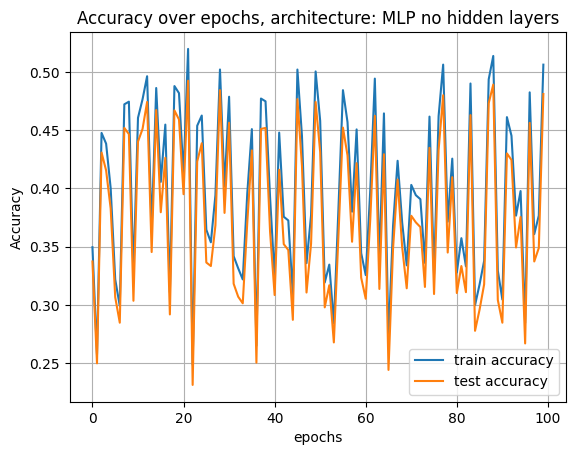

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           0.2095           |
+----------------------------+


In [5]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
mlp_no_hidden_layers = MLPSoftmax(initalizer=random_initalizer, activation_functions=[activation_loss_function], layer_sizes=[784, 11]) #We know the dimensions from torch.flatten()
mlp_no_hidden_layers.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.01,
                         epochs=100, batch=256, termination_condition=1e-3, max_iters=100, display_plot=True, save_figure_name= "MLP_no", architecture_title="MLP no hidden layers")

Memory Log averaged: 950MB

Exploration of parameters:

Epoch 99
Final Train accuracy: 0.27217158564814814
Final Test accuracy: 0.2642846810357298
Saving Image


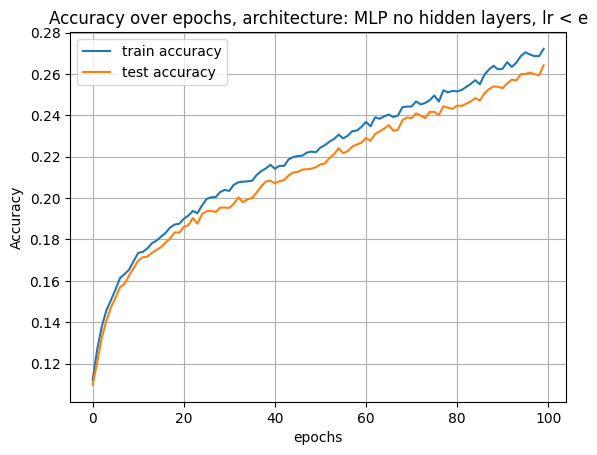

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           0.2429           |
+----------------------------+


In [6]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
mlp_no_hidden_layers = MLPSoftmax(initalizer=random_initalizer, activation_functions=[activation_loss_function], layer_sizes=[784, 11]) #We know the dimensions from torch.flatten()
mlp_no_hidden_layers.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.0001,
                         epochs=100, batch=256, termination_condition=1e-3, max_iters=100, display_plot=True, save_figure_name= "MLP_no_low_learning", architecture_title="MLP no hidden layers, lr < e")

Epoch 99
Final Train accuracy: 0.5059678819444444
Final Test accuracy: 0.47577028786344566
Saving Image


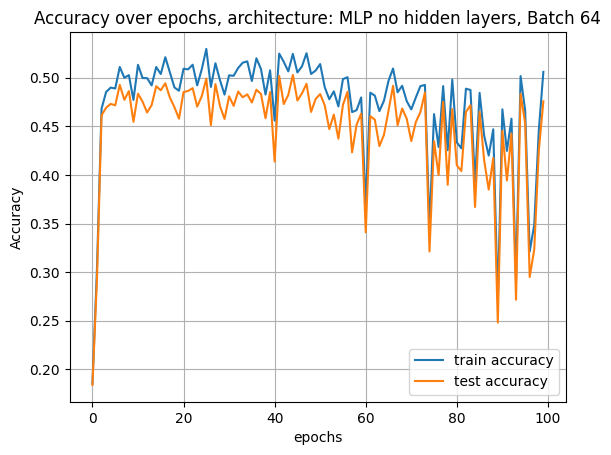

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           0.5842           |
+----------------------------+


In [7]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
mlp_no_hidden_layers = MLPSoftmax(initalizer=random_initalizer, activation_functions=[activation_loss_function], layer_sizes=[784, 11]) #We know the dimensions from torch.flatten()
mlp_no_hidden_layers.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.01,
                         epochs=100, batch=64, termination_condition=1e-3, max_iters=100, display_plot=True, save_figure_name= "MLP_no_B_64", architecture_title="MLP no hidden layers, Batch 64")

## (2) MLP with single layer (256 Units) and Relu activation.

Epoch 99
Final Train accuracy: 0.7530743634259259
Final Test accuracy: 0.7423694488644582
Saving Image


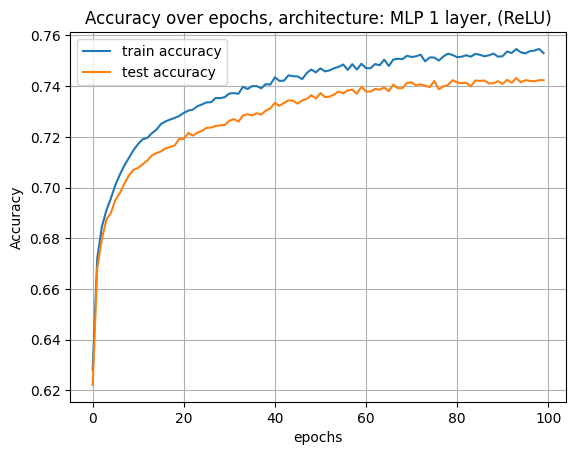

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           1.4682           |
+----------------------------+


In [6]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_relu = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
mlp_1_hidden_layers_relu = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions = [activation_loss_function, activation_function_relu], layer_sizes=[784,256, 11]) #We know the dimensions from torch.flatten()
mlp_1_hidden_layers_relu.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.001,
                         epochs=100, batch=128, termination_condition=1e-2, max_iters=1000, display_plot=True, save_figure_name="MLP_1_Relu", architecture_title="MLP 1 layer, (ReLU)")

Memory Log averaged: 1000MB

Exploration of paramaters:

Epoch 99
Final Train accuracy: 0.7266710069444444
Final Test accuracy: 0.7185013742224794
Saving Image


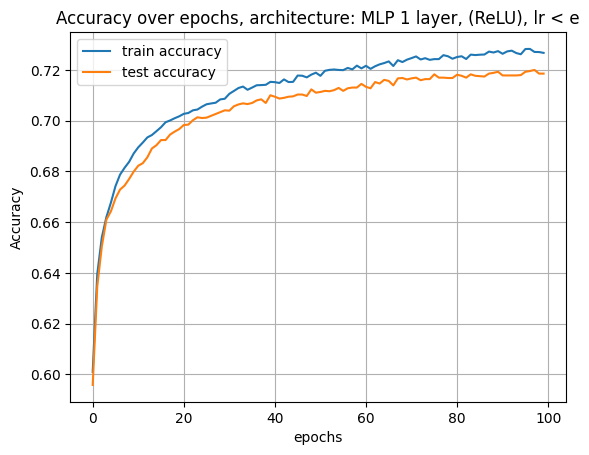

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           1.7163           |
+----------------------------+


In [9]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_relu = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
mlp_1_hidden_layers_relu = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions = [activation_loss_function, activation_function_relu], layer_sizes=[784,256, 11]) #We know the dimensions from torch.flatten()
mlp_1_hidden_layers_relu.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.001,
                         epochs=100, batch=128, termination_condition=1e-2, max_iters=1000, display_plot=True, save_figure_name="MLP_1_Relu_low_learning_rate", architecture_title="MLP 1 layer, (ReLU), lr < e")

Epoch 99
Final Train accuracy: 0.69921875
Final Test accuracy: 0.6900043396499349
Saving Image


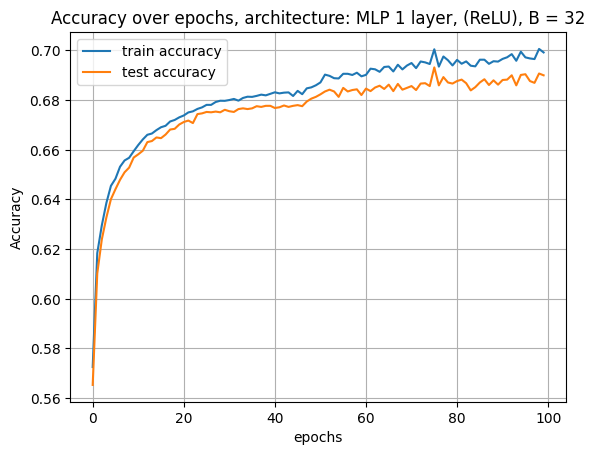

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           3.6938           |
+----------------------------+


In [10]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_relu = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
mlp_1_hidden_layers_relu = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions = [activation_loss_function, activation_function_relu], layer_sizes=[784,256, 11]) #We know the dimensions from torch.flatten()
mlp_1_hidden_layers_relu.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.001,
                         epochs=100, batch=32, termination_condition=1e-2, max_iters=1000, display_plot=True, save_figure_name="MLP_1_Relu_low_batch_size", architecture_title="MLP 1 layer, (ReLU), B = 32")

With the low learning rate or low batch size we get a much longer execution time. (3.69s per epoch for low batch size!) Thus we keep B = 128-256 and lr = 0.01 or 0.001. Additionally with a higher learning rate and larger batch size we gained the highest score of the three experiements. Lower learning rates tended to give worse results.

## (3) MLP with two hidden units (256, 256) and Relu activation. 

Epoch 99
Final Train accuracy: 0.9296151620370371
Final Test accuracy: 0.8988861565167077
Saving Image


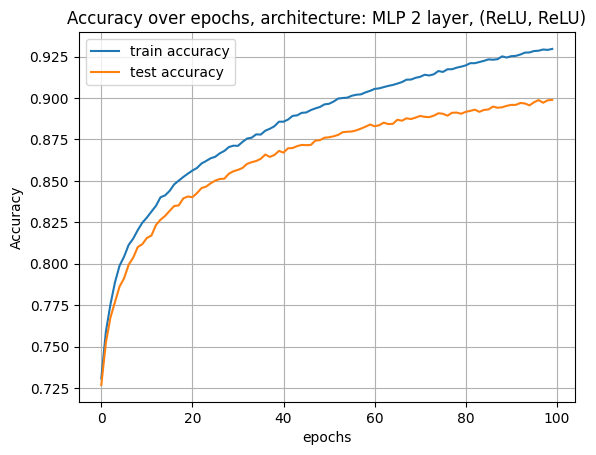

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           1.5458           |
+----------------------------+


In [ ]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_relu = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
activation_function_relu_2 = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
mlp_2_hidden_layers_relu = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_relu, activation_function_relu_2], layer_sizes=[784,256,256,11]) #We know the dimensions from torch.flatten()
mlp_2_hidden_layers_relu.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.001,
                         epochs=100, batch=256, termination_condition=1e-2, max_iters=1000, display_plot=True, save_figure_name="MLP_2_Relu", architecture_title="MLP 2 layer, (ReLU, ReLU)")

Memory Log Averaged: 1025MB

Hyperparamater exploration:

Epoch 99
Final Train accuracy: 0.8257378472222222
Final Test accuracy: 0.8183133227253001
Saving Image


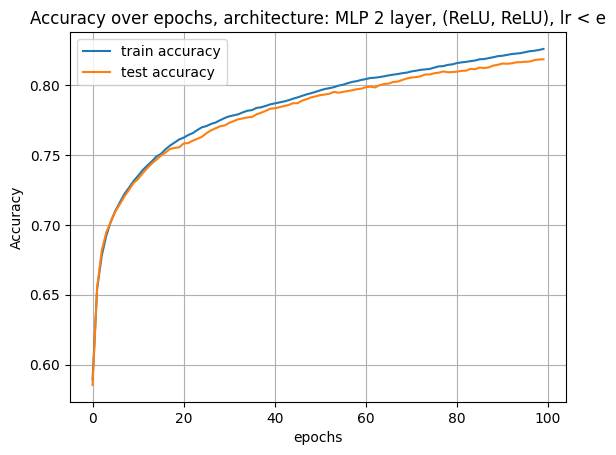

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           1.7225           |
+----------------------------+


In [11]:

activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_relu = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
activation_function_relu_2 = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
mlp_2_hidden_layers_relu = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_relu, activation_function_relu_2], layer_sizes=[784,256,256,11]) #We know the dimensions from torch.flatten()
mlp_2_hidden_layers_relu.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.0001,
                         epochs=100, batch=256, termination_condition=1e-2, max_iters=1000, display_plot=True, save_figure_name="MLP_2_Relu_low_learning_rate", architecture_title="MLP 2 layer, (ReLU, ReLU), lr < e")

Epoch 17
Final Train accuracy: 0.7581018518518519
Final Test accuracy: 0.7537971936930421


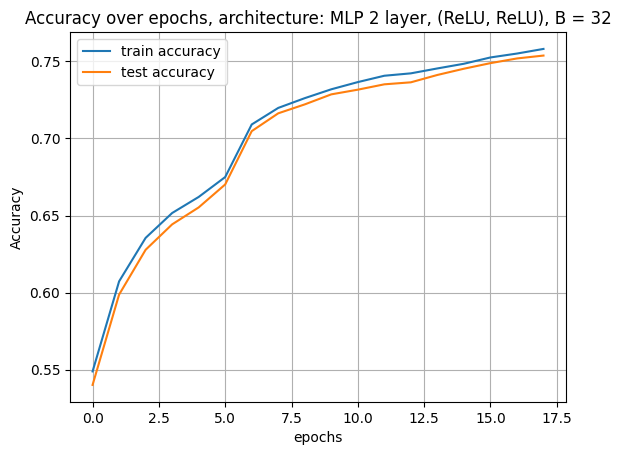

KeyboardInterrupt: 

In [ ]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_relu = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
activation_function_relu_2 = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
mlp_2_hidden_layers_relu = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_relu, activation_function_relu_2], layer_sizes=[784,256,256,11]) #We know the dimensions from torch.flatten()
mlp_2_hidden_layers_relu.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.001,
                         epochs=100, batch=32, termination_condition=1e-2, max_iters=1000, display_plot=True, save_figure_name="MLP_2_Relu_low_batch_size", architecture_title="MLP 2 layer, (ReLU, ReLU), B = 32")

# Task 3.2

## MLP with two hidden layers (256, 256) and tanh activations

Epoch 99
Final Train accuracy: 0.6995442708333334
Final Test accuracy: 0.6860986547085202
Saving Image


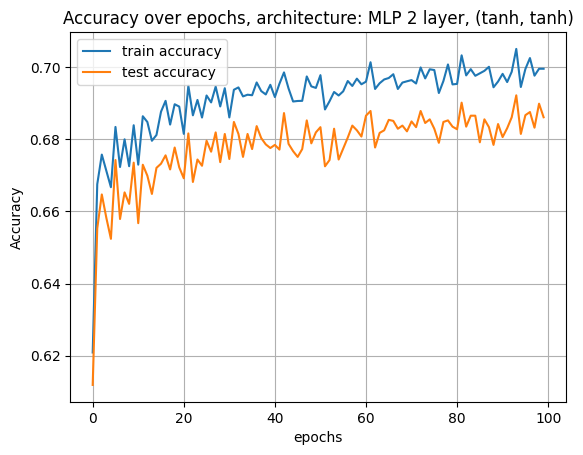

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           2.5747           |
+----------------------------+


In [ ]:

activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_tanh = ActivationFunction(func = tanh, derivative= tanh_derivative)
activation_function_tanh_2 = ActivationFunction(func = tanh, derivative= tanh_derivative)
mlp_2_hidden_layers_relu = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_tanh, activation_function_tanh_2], layer_sizes=[784,256,256,11]) #We know the dimensions from torch.flatten()
mlp_2_hidden_layers_relu.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.001,
                         epochs=100, batch=256, termination_condition=1e-2, max_iters=1000, display_plot=True, save_figure_name="MLP_2_Tanh", architecture_title="MLP 2 layer, (tanh, tanh)")

Memory Log Averaged: 1100 MB

## MLP with two hidden layers (256, 256) and leaky-ReLU

Epoch 99
Final Train accuracy: 0.9441912615740741
Final Test accuracy: 0.9134963112975554
Saving Image


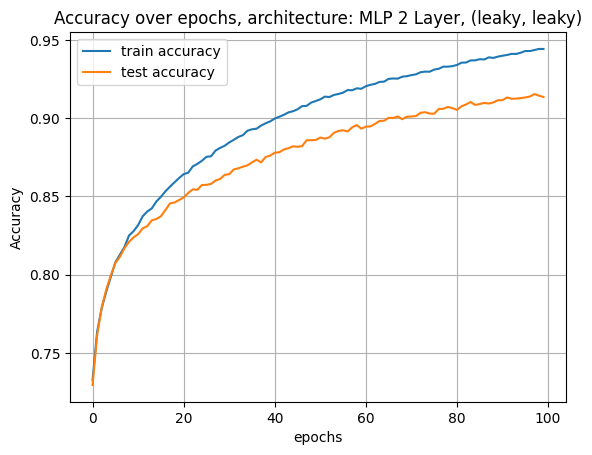

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           1.6356           |
+----------------------------+


In [ ]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_leaky = ActivationFunction(func = leaky_ReLU, derivative= leaky_ReLU_derivative)
activation_function_leaky_2 = ActivationFunction(func = leaky_ReLU, derivative= leaky_ReLU_derivative)
mlp_2_hidden_layers_leaky = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_leaky, activation_function_leaky_2], layer_sizes=[784,256,256,11]) #We know the dimensions from torch.flatten()
mlp_2_hidden_layers_leaky.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.001,
                         epochs=100, batch=256, termination_condition=1e-2, max_iters=1000, display_plot=True, save_figure_name="MLP_2_leaky", architecture_title="MLP 2 Layer, (leaky, leaky)")

Memory Log Averaged: 1130MB

## Explore activation functions / combinations of activation functions (Creative)

## MLP with two hidden units(256, 256) and Sigmoid activations

Epoch 99
Final Train accuracy: 0.6660517939814815
Final Test accuracy: 0.6606393750904094
Saving Image


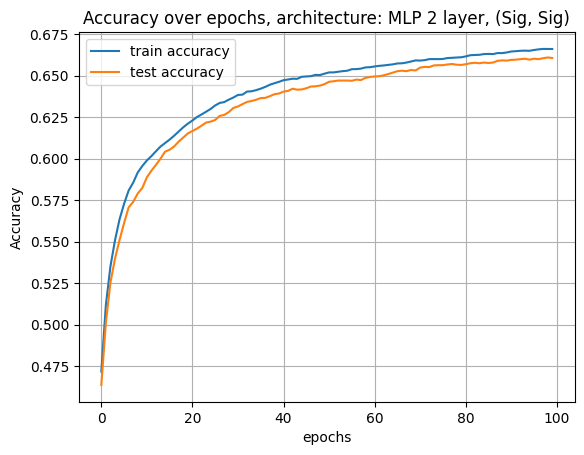

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           1.9532           |
+----------------------------+


In [6]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_sigmoid = ActivationFunction(func = sigmoid, derivative= sigmoid_derivative)
activation_function_sidmoid_2 = ActivationFunction(func = sigmoid, derivative= sigmoid_derivative)
mlp_2_hidden_layers_sigmoid = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_sigmoid, activation_function_sidmoid_2], layer_sizes=[784,256,256,11]) #We know the dimensions from torch.flatten()
mlp_2_hidden_layers_sigmoid.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.001,
                         epochs=100, batch=256, termination_condition=1e-2, max_iters=1000, display_plot=True, save_figure_name="MLP_2_Sigmoid", architecture_title="MLP 2 layer, (Sig, Sig)")

# MLP with two hidden units(256, 256), Sigmoid activation, Leaky activation

Epoch 99
Final Train accuracy: 0.7462745949074074
Final Test accuracy: 0.7425141038622884
Saving Image


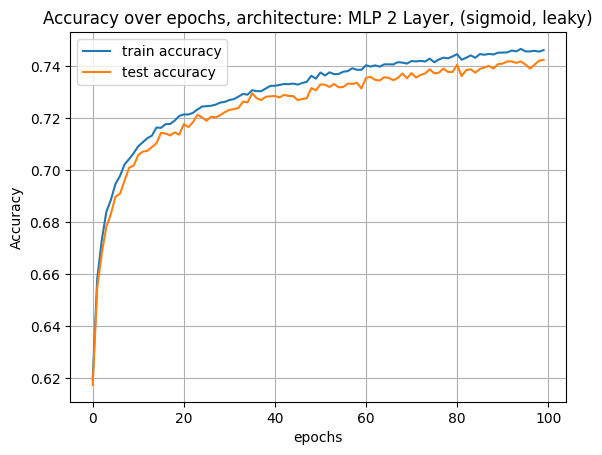

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           2.1175           |
+----------------------------+


In [8]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_leaky = ActivationFunction(func = leaky_ReLU, derivative= leaky_ReLU_derivative)
activation_function_sigmoid = ActivationFunction(func = sigmoid, derivative= sigmoid_derivative)
mlp_2_hidden_layers_sigmoid_leaky = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_sigmoid, activation_function_leaky], layer_sizes=[784,256,256,11]) #We know the dimensions from torch.flatten()
mlp_2_hidden_layers_sigmoid_leaky.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.001,
                         epochs=100, batch=256, termination_condition=1e-2, max_iters=1000, display_plot=True, save_figure_name="MLP_2_sigmoid_leaky", architecture_title="MLP 2 Layer, (sigmoid, leaky)")

## MLP 3 hidden units (256, 256, 256), Leaky, Leaky, Leaky

Epoch 99
Final Train accuracy: 0.9411530671296297
Final Test accuracy: 0.9019239114711414
Saving Image


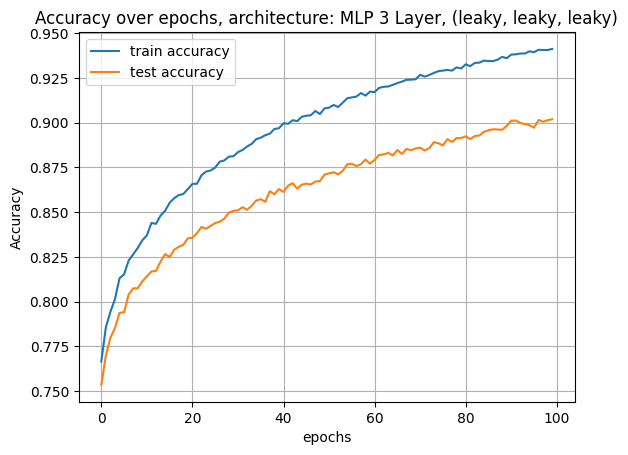

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           2.3658           |
+----------------------------+


In [10]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_leaky = ActivationFunction(func = leaky_ReLU, derivative= leaky_ReLU_derivative)
activation_function_leaky_2 = ActivationFunction(func = leaky_ReLU, derivative= leaky_ReLU_derivative)
activation_function_leaky_3 = ActivationFunction(func = leaky_ReLU, derivative= leaky_ReLU_derivative)
mlp_2_hidden_layers_leakys = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_leaky, activation_function_leaky_2, activation_function_leaky_3], layer_sizes=[784,256,256,256,11]) #We know the dimensions from torch.flatten()
mlp_2_hidden_layers_leakys.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.001,
                         epochs=100, batch=256, termination_condition=1e-2, max_iters=1000, display_plot=True, save_figure_name="MLP_3_leaky", architecture_title="MLP 3 Layer, (leaky, leaky, leaky)")

Notice! We are trending to overfitting as the gap between train and test has increased much more compared to the 2 layer leaky model.

# Task 3.3

## MLP with two hidden units (256, 256), ReLU activation with L2 regularization.

Notice lots of reguralization terms caused a degradation over the weights. We had to keep the strength quite small in order not to see this.

Epoch 99
Final Train accuracy: 0.5713252314814815
Final Test accuracy: 0.564443801533343
Saving Image


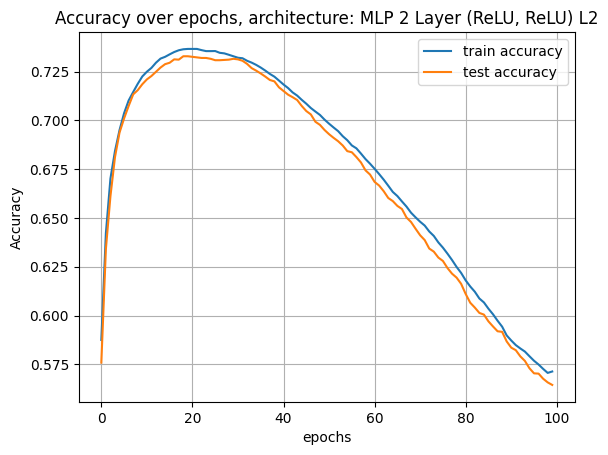

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           1.7169           |
+----------------------------+


In [ ]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_relu = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
activation_function_relu_2 = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
mlp_2_hidden_layers_relu = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_relu, activation_function_relu_2], layer_sizes=[784,256,256,11])
mlp_2_hidden_layers_relu.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.0001,
                         epochs=100, batch=256, termination_condition=1e-2, max_iters=1000, display_plot=True,save_figure_name="MLP_2_Relu_L2", architecture_title="MLP 2 Layer (ReLU, ReLU) L2", lambbda = 0.001, regularization = 'l2')

Memory Log Average: 1130 MB

## MLP with two hidden units (256, 256), ReLU activation with L1 regularization.

Again, we keep the reguralization strenght quite small to avoid a "quick" degredation of accuracy

Epoch 99
Final Train accuracy: 0.8225549768518519
Final Test accuracy: 0.8077535078836974
Saving Image


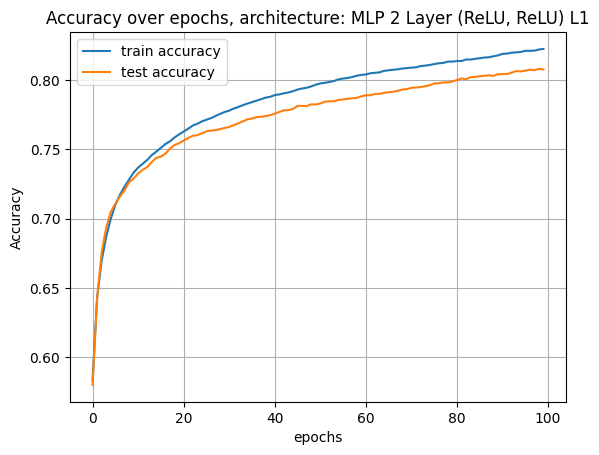

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           1.6603           |
+----------------------------+


In [ ]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_relu = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
activation_function_relu_2 = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
mlp_2_hidden_layers_relu = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_relu, activation_function_relu_2], layer_sizes=[784,256,256,11])
mlp_2_hidden_layers_relu.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.0001,
                         epochs=100, batch=256, termination_condition=1e-2, max_iters=1000, display_plot=True, lambbda = 0.001, save_figure_name= "MLP_2_Relu_L1", architecture_title="MLP 2 Layer (ReLU, ReLU) L1", regularization = 'l1')

We observe great results here! It seems like reguralization is taking effect by having the training accuracy and test accuracy lower (but within reason). 

Memory Log Averaged: 1130MB

# Task 3.4

## MLP with two hidden units (257, 256) and Relu activation (Unormalized data)

In [13]:
X_train, y_train, X_test, y_test = get_data(normalized=False)

=== Downloading data ===
Using downloaded and verified file: /home/sebastiancsabry/.medmnist/organamnist.npz
=== Finished downloading ===
The new feature flattened length is 784


Epoch 99
Final Train accuracy: 0.17975983796296297
Final Test accuracy: 0.172718067409229
Saving Image


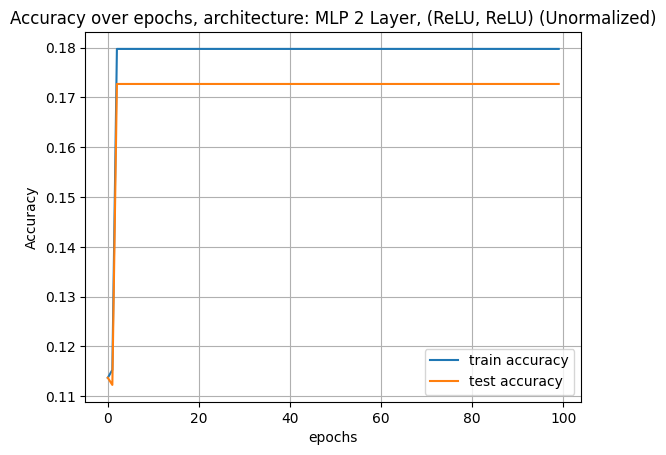

+----------------------------+
| Average Time per epoch (s) |
+----------------------------+
|           1.2525           |
+----------------------------+


In [ ]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_relu = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
activation_function_relu_2 = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
mlp_2_hidden_layers_relu_un = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_relu, activation_function_relu_2], layer_sizes=[784,256,256,11]) #We know the dimensions from torch.flatten()
mlp_2_hidden_layers_relu_un.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.001,
                         epochs=100, batch=256, termination_condition=1e-2, max_iters=1000, use_batch_normalization= False, display_plot=True, save_figure_name="MLP_2_Relu_Unormalized", architecture_title="MLP 2 Layer, (ReLU, ReLU) (Unormalized)" ) #Set batch normalization to false

# Task 3.5

Since the dataset is much larger we have to do different data preprocessing.

In [15]:
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])


# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std = [1])
])


# load the data
print("=== Downloading data ===")
train_dataset_128 = DataClass(split='train', transform=data_transform, download=download, size = 128, mmap_mode = 'r')
test_dataset_128 = DataClass(split='test', transform=data_transform, download=download, size = 128, mmap_mode = 'r')
print("=== Finished downloading ===")

=== Downloading data ===
Using downloaded and verified file: /home/sebastiancsabry/.medmnist/organamnist_128.npz
Using downloaded and verified file: /home/sebastiancsabry/.medmnist/organamnist_128.npz
=== Finished downloading ===


In [16]:
print(train_dataset_128)

Dataset OrganAMNIST of size 128 (organamnist_128)
    Number of datapoints: 34561
    Root location: /home/sebastiancsabry/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34561, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28

In [17]:
def format_data(train_dataset):
    num_samples = len(train_dataset)
    num_classes = 11

    X = np.zeros((num_samples, 128*128), dtype=np.float32)
    y = np.zeros((num_samples, 1), dtype=np.int8)
    # X = np.array([train_dataset[i][0].numpy() for i in range(len(train_dataset))])  # Image data as numpy array
    # y = np.array([train_dataset[i][1] for i in range(len(train_dataset))])  # Labels
    for i in range(num_samples):
        image, label = train_dataset[i]
        X[i] = image.numpy().flatten()
        y[i] = label

    print(f"The new feature flattened length is {X.shape}")
    y = np.eye(num_classes)[y]
    y = np.squeeze(y)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    y_train, y_test = train_test_split(y, test_size= 0.2, random_state=42)

    return X_train, y_train, X_test, y_test

## MLP with two hidden units (256, 256), ReLU activation with L1 regularization. (128x128px)

Our MLP architecture fails on this size of flattened data. I suspect the RAM is overflowing due to the mutiplcations under matmul

In [18]:
X_train, y_train, X_test, y_test = format_data(train_dataset_128)

The new feature flattened length is (34561, 16384)


In [20]:
activation_loss_function = ActivationFunction(func=softmax, derivative=softmax_derivative)
activation_function_relu = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
activation_function_relu_2 = ActivationFunction(func = ReLU, derivative= ReLU_derivative)
mlp_2_hidden_layers_relu_128 = MLPSoftmax(initalizer=random_optimized_initalizer, activation_functions=[activation_loss_function, activation_function_relu, activation_function_relu_2], layer_sizes=[16384,256,256,11])
mlp_2_hidden_layers_relu_128.fit(X_train= X_train, y_train= y_train, X_test=X_test, y_test=y_test, learning_rate=0.1,
                         epochs=100, batch=512, termination_condition=1e-2, max_iters=100, plot=True, save_figure_name="128_MLP", architecture_title="128x128 Test")

: 

Show kernel RAM usage over time as an indicator?